In [1]:
import argparse
import os
import random
import shutil
import time
import warnings
import sys
from tqdm import tqdm
import glob
import PIL
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
from torch.autograd import Variable
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.spatial.distance as ssd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'dist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [40]:
# load models
resnet18 = torchvision.models.resnet18(pretrained=True)
squeezenet = torchvision.models.squeezenet1_0(pretrained=True)
alexnet = torchvision.models.alexnet(pretrained=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /Users/Colin/.torch/models/squeezenet1_0-a815701f.pth
100%|██████████| 5017600/5017600 [00:00<00:00, 8365400.42it/s]


In [41]:
resnet_len = len(resnet18.state_dict())
squeezenet_len = len(squeezenet.state_dict())
alexnet_len = len(alexnet.state_dict())

In [43]:
print(resnet_len)
print(squeezenet_len)
print(alexnet_len)

122
52
16


In [44]:
# get model that has output of representation before final fc layer
resnet18_last = nn.Sequential(*list(resnet18.children())[:-1])
resnet_18_50pct = nn.Sequential(*list(resnet18.children())[:int(-resnet_len/2)])
resnet_18_75pct = nn.Sequential(*list(resnet18.children())[:int(-resnet_len/4)])

squeezenet_last = nn.Sequential(*list(squeezenet.children())[:-1])
squeezenet_50pct = nn.Sequential(*list(squeezenet.children())[:int(-inception_len/2)])
squeezenet_75pct = nn.Sequential(*list(squeezenet.children())[:int(-inception_len/4)])

alexnet_last = nn.Sequential(*list(alexnet.children())[:-1])
alexnet_50pct = nn.Sequential(*list(alexnet.children())[:int(-inception_len/2)])
alexnet_75pct = nn.Sequential(*list(alexnet.children())[:int(-inception_len/4)])

In [8]:
file_list = ['image_1.jpg',
             'image_2.jpg',
             'image_3.jpg',
             'image_4.jpg',
             'image_5.jpg',
             'image_6.jpg',
             'image_7.jpg',
             'image_8.jpg',
             'image_9.jpg',
             'image_10.jpg']

In [45]:
size = 299
image_tensor_list = []
for i in file_list:
    cur_img = PIL.Image.open(i)
    cur_img = transforms.functional.resize(cur_img, size)
    cur_mat = np.asarray(cur_img) / 256.0
    cur_tensor = torch.from_numpy(cur_mat).view(1,size,size,-1).permute(0,3,1,2)
    cur_tensor.type(torch.DoubleTensor)
    image_tensor_list.append(cur_tensor)
print(image_tensor_list[0].shape)

torch.Size([1, 3, 299, 299])


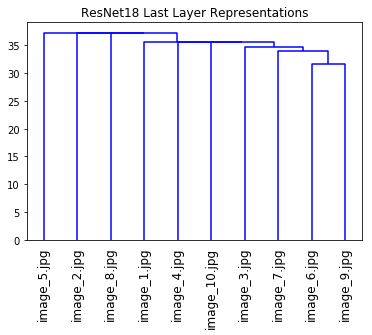

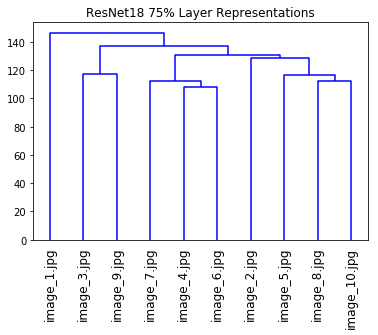

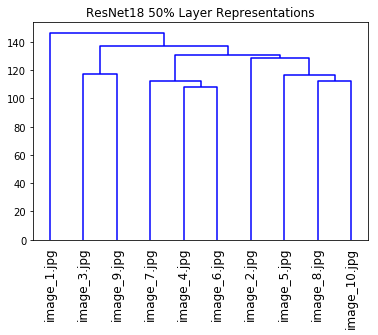

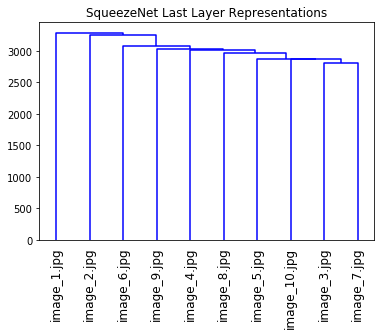

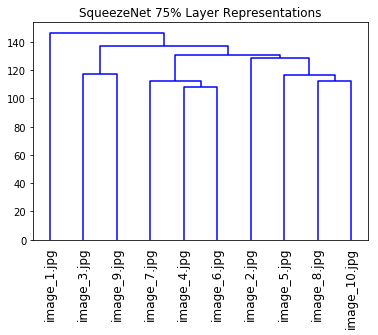

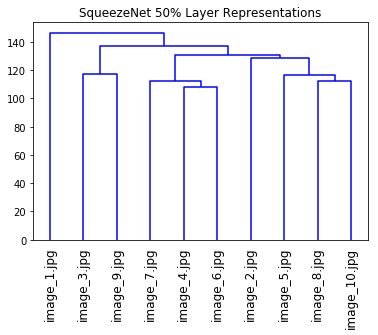

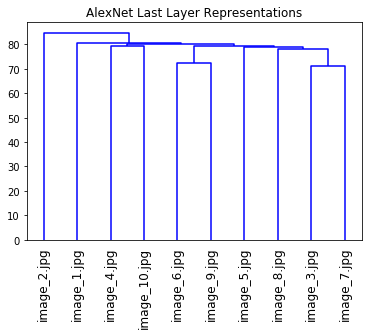

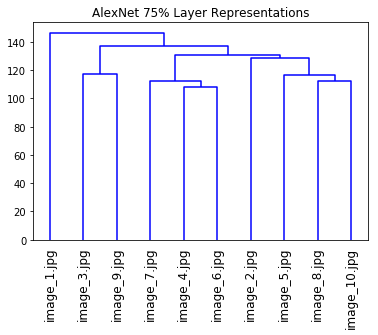

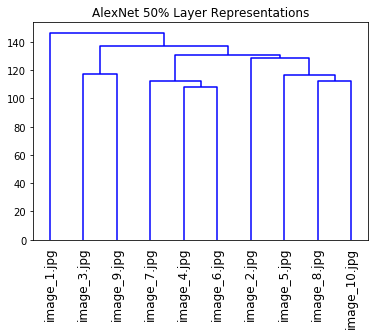

In [48]:
model_list = [resnet18_last, resnet18_75pct, resnet18_50pct,
             squeezenet_last, squeezenet_50pct, squeezenet_75pct,
            alexnet_last, alexnet_75pct, alexnet_50pct]

title_list = ['ResNet18 Last Layer Representations', 
             'ResNet18 75% Layer Representations',
             'ResNet18 50% Layer Representations',
             'SqueezeNet Last Layer Representations',
            'SqueezeNet 75% Layer Representations',
            'SqueezeNet 50% Layer Representations',
             'AlexNet Last Layer Representations', 
             'AlexNet 75% Layer Representations',
             'AlexNet 50% Layer Representations']
for idx, model in enumerate(model_list):
    model.double()
    rep_list = []
    for img_tensor in image_tensor_list:
        cur_rep = model(img_tensor)
        cur_rep = cur_rep.contiguous().view(-1).detach().numpy()
        rep_list.append(cur_rep)
    rep_mat = np.array(rep_list)
    linked = linkage(rep_mat,'single')
    dendrogram(linked, labels=file_list, truncate_mode='level')
    plt.xticks(rotation=90)
    plt.title(title_list[idx])
    #plt.ylim((80,100))
    plt.show()

In [10]:
# read in mturk results similarity matrix
mturk_distance_mat = pd.read_csv('similarty_mturk - Sheet1.csv', index_col=0).as_matrix()
mturk_distance_mat = mturk_distance_mat + mturk_distance_mat.T
mturk_distance_mat = 10 - mturk_distance_mat
np.fill_diagonal(mturk_distance_mat, 0)
mturk_distance_mat

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([[0. , 5.3, 4.6, 6.1, 3.7, 5.2, 4.6, 4.2, 5.2, 4.5],
       [5.3, 0. , 5.7, 2.9, 5.2, 5.6, 4.8, 7.1, 4.7, 4.5],
       [4.6, 5.7, 0. , 5.5, 5.9, 6. , 4.4, 3.8, 3.6, 5.3],
       [6.1, 2.9, 5.5, 0. , 4.9, 5.7, 5.3, 6.2, 5.5, 3.8],
       [3.7, 5.2, 5.9, 4.9, 0. , 3.4, 5.9, 3.6, 4.2, 3.6],
       [5.2, 5.6, 6. , 5.7, 3.4, 0. , 3.1, 3.6, 2.7, 4.4],
       [4.6, 4.8, 4.4, 5.3, 5.9, 3.1, 0. , 4.8, 3.5, 5.4],
       [4.2, 7.1, 3.8, 6.2, 3.6, 3.6, 4.8, 0. , 4.1, 5.2],
       [5.2, 4.7, 3.6, 5.5, 4.2, 2.7, 3.5, 4.1, 0. , 4.9],
       [4.5, 4.5, 5.3, 3.8, 3.6, 4.4, 5.4, 5.2, 4.9, 0. ]])

In [11]:
#b = np.random.random_integers(5,size=(10,10))
#b_symm = (b + b.T)/2
#np.fill_diagonal(b_symm, 0)
#b_symm

Text(0.5,1,'Mturk Similarity Dendrogram')

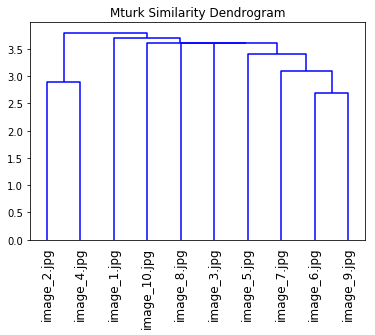

In [13]:
distVec = ssd.squareform(mturk_distance_mat)
link = linkage(distVec)
dendro  = dendrogram(link, labels=file_list)
plt.xticks(rotation=90)
plt.title('Mturk Similarity Dendrogram')

In [16]:
# read in friends results similarity matrix
trusted_distance_mat = pd.read_csv('similarty_mturk - Sheet5.csv', header=None, index_col=None).as_matrix()
trusted_distance_mat
trusted_distance_mat = trusted_distance_mat + trusted_distance_mat.T
trusted_distance_mat = 10 - trusted_distance_mat
np.fill_diagonal(trusted_distance_mat, 0)
trusted_distance_mat

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([[0.        , 5.5       , 2.66666667, 4.66666667, 6.        ,
        5.        , 4.        , 2.75      , 2.66666667, 4.        ],
       [5.5       , 0.        , 7.        , 4.        , 5.14285714,
        5.        , 6.        , 8.        , 6.8       , 7.        ],
       [2.66666667, 7.        , 0.        , 8.        , 5.33333333,
        6.        , 4.        , 3.        , 3.66666667, 4.85714286],
       [4.66666667, 4.        , 8.        , 0.        , 6.85714286,
        6.5       , 5.        , 7.33333333, 5.2       , 5.6       ],
       [6.        , 5.14285714, 5.33333333, 6.85714286, 0.        ,
        2.        , 4.4       , 3.5       , 6.        , 3.5       ],
       [5.        , 5.        , 6.        , 6.5       , 2.        ,
        0.        , 4.        , 5.33333333, 1.75      , 1.33333333],
       [4.        , 6.        , 4.        , 5.        , 4.4       ,
        4.        , 0.        , 6.        , 0.66666667, 4.28571429],
       [2.75      , 8.        , 3.       

Text(0.5,1,'Google Survey Similarity Dendrogram')

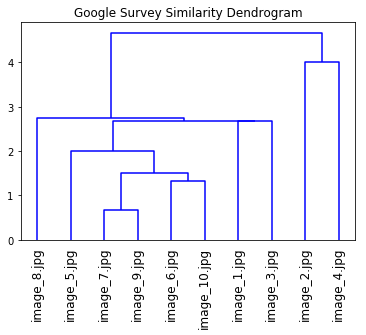

In [19]:
distVec = ssd.squareform(trusted_distance_mat)
link = linkage(distVec)
dendro  = dendrogram(link, labels=file_list, color_threshold=0)
plt.xticks(rotation=90)
plt.title('Google Survey Similarity Dendrogram')

In [20]:
distVec

array([5.5       , 2.66666667, 4.66666667, 6.        , 5.        ,
       4.        , 2.75      , 2.66666667, 4.        , 7.        ,
       4.        , 5.14285714, 5.        , 6.        , 8.        ,
       6.8       , 7.        , 8.        , 5.33333333, 6.        ,
       4.        , 3.        , 3.66666667, 4.85714286, 6.85714286,
       6.5       , 5.        , 7.33333333, 5.2       , 5.6       ,
       2.        , 4.4       , 3.5       , 6.        , 3.5       ,
       4.        , 5.33333333, 1.75      , 1.33333333, 6.        ,
       0.66666667, 4.28571429, 4.85714286, 5.71428571, 1.5       ])